In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
# read as hdf5 instead
import h5py
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File('/Users/[REDACTED]/embedders/data/528733620_ephys.nwb', 'r') as f:
#     # Read the NWB file
#     print(f.keys())

#     # Get all time series
#     ts = f['acquisition/timeseries']
#     ts

data = h5py.File("../data/electrophysiology/623474383_ephys.nwb", "r")
data

<HDF5 file "623474383_ephys.nwb" (mode r)>

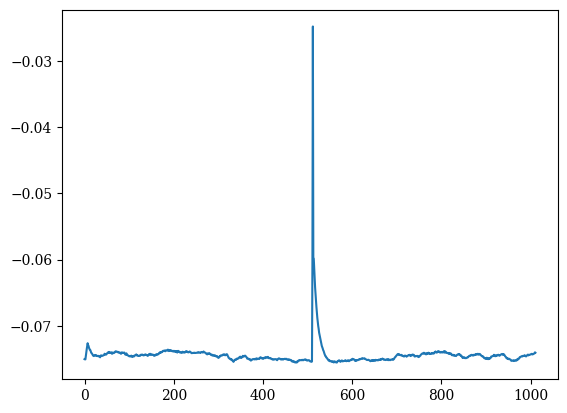

In [33]:
plt.plot(np.array(data["acquisition/timeseries/Sweep_15/data"])[::100])

In [34]:
# np.array([data[f"acquisition/timeseries/Sweep_{n}/data"] for n in range(1, 63)])
all_ts = []
for n in range(1, 63):
    try:
        all_ts.append(np.array(data[f"acquisition/timeseries/Sweep_{n}/data"]))
    except:
        pass
[x.shape for x in all_ts]

[(1701000,),
 (1701000,),
 (1701000,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (101150,),
 (401000,),
 (401000,),
 (401000,),
 (401000,),
 (401000,),
 (401000,),
 (401000,),
 (401000,),
 (401000,),
 (301000,),
 (301000,),
 (301000,),
 (301000,),
 (1401000,),
 (1401000,),
 (1401000,),
 (1401000,),
 (1401000,),
 (1401000,),
 (412000,),
 (412000,),
 (412000,),
 (412000,),
 (412000,),
 (412000,),
 (412000,),
 (412000,)]

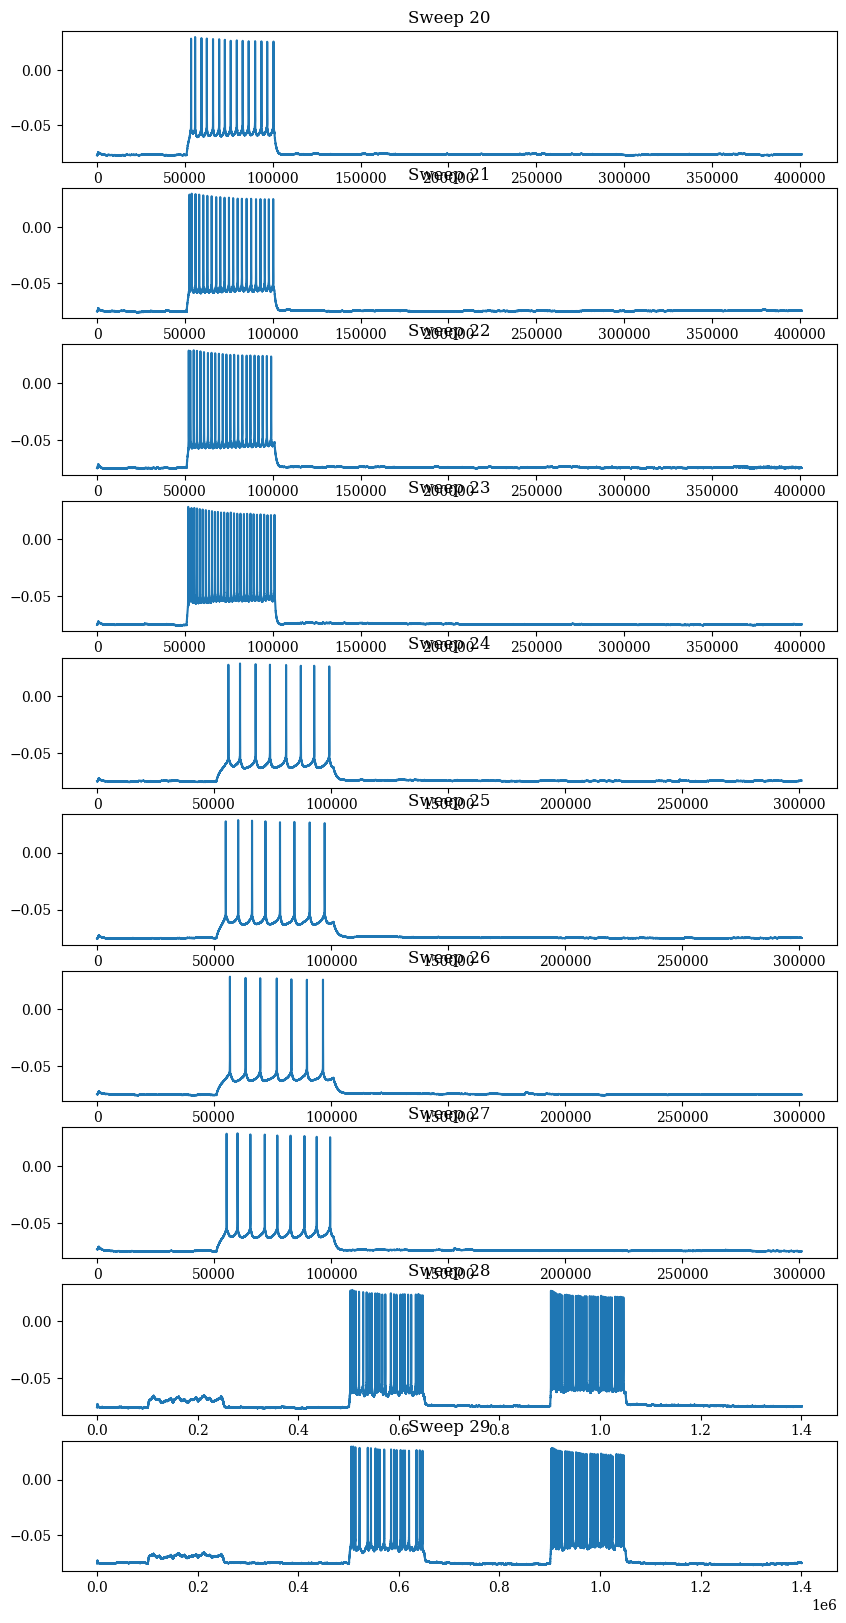

In [35]:
OFFSET = 20
fig, axs = plt.subplots(10, 1, figsize=(10, 20))
for i in range(10):
    axs[i].plot(all_ts[i + OFFSET])
    axs[i].set_title(f"Sweep {i + OFFSET}")

(401000,)


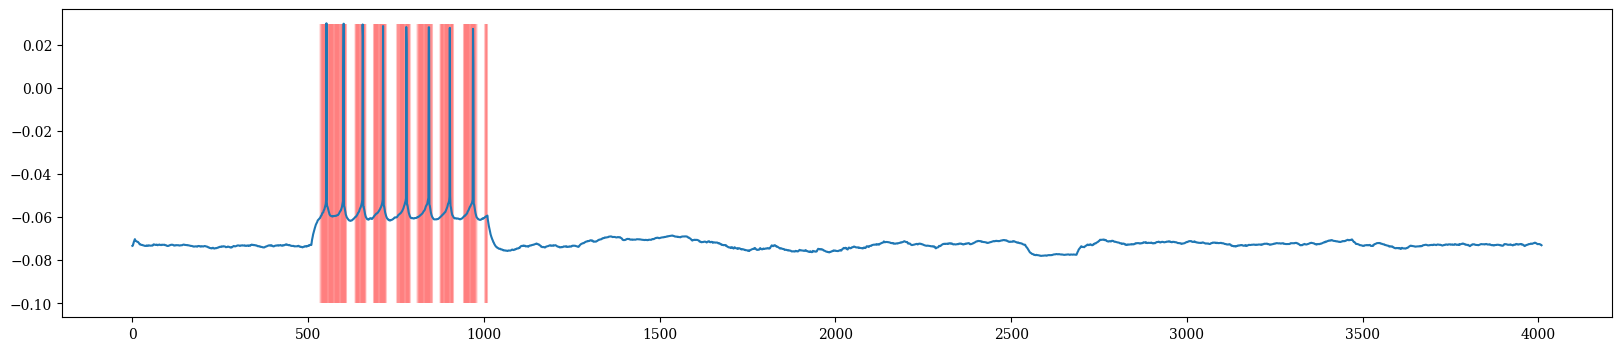

In [36]:
# Downsample
# X = all_ts[32]
X = np.array(data["acquisition/timeseries/Sweep_33/data"])
# X = np.array(data["acquisition/timeseries/Sweep_46/data"])
X_downsampled = X.reshape(-1, 100).max(axis=1).reshape(-1)

# Get spike annotations
y_labels = X_downsampled > -0.06
y_coords = np.arange(len(X_downsampled))[y_labels]

# Verify that downsampling worked
print(X.shape)
fig = plt.figure(figsize=(20, 4))
plt.vlines(y_coords, ymin=-0.1, ymax=0.03, color="r", alpha=0.1)
plt.plot(X_downsampled)

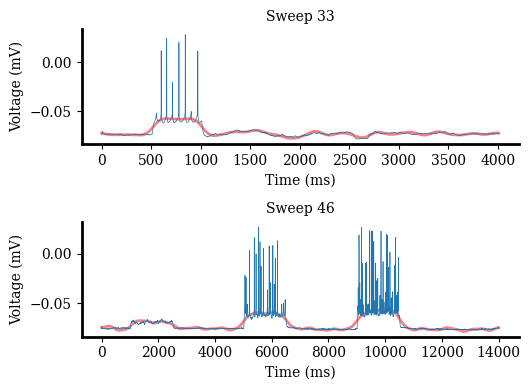

In [37]:
from scipy.fft import fft, ifft

# Set font to LaTeX times font
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

fig, axs = plt.subplots(2, 1, figsize=(5.5, 4))#, sharex=True)
for ax, n in zip(axs, [33, 46]):
    # Plot X
    X = np.array(data[f"acquisition/timeseries/Sweep_{n}/data"])
    # ax.plot(X, linewidth=0.5)

    # Plot X ~ approximated by top 5 fourier components
    X_fft = fft(X)
    top_5_idx = np.argsort(np.abs(X_fft))[::-1][:20]

    X_fft_approx = np.zeros_like(X_fft)
    X_fft_approx[top_5_idx] = X_fft[top_5_idx]
    X_approx = ifft(X_fft_approx).real
    ax.plot(X_approx[::100], linewidth=2, color="r", alpha=0.5)
    ax.plot(X[::100], linewidth=0.5)

    # Bunch of formatting
    ax.set_title(f"Sweep {n}", position=(0.5, 0.9), fontsize=10)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("Voltage (mV)", fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)

    # Font size for ticks
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.tick_params(axis="both", which="minor", labelsize=10)

plt.tight_layout()
plt.savefig("../figures/fourier_approx.pdf")

In [40]:
# This is the part where we embed into (S1)^d

from scipy.fftpack import fft, fftfreq

N_MANIFOLDS = 3
N_SAMPLES = 1_000  # Magic number : # positive samples

# Load data
data = h5py.File("../data/electrophysiology/623474383_ephys.nwb", "r")
X = np.array(data["acquisition/timeseries/Sweep_33/data"])

# Get all fourier components
Xf = fft(X)
freqs = fftfreq(len(X), d=1.0)  # TODO: Figure out what the sampling rate is

# Get top 5 components by magnitude
top_inds = np.argsort(np.abs(Xf))[-N_MANIFOLDS - 1 : -1]  # Avoid dividing by 0 this way
top_freqs = freqs[top_inds]
top_Xf = Xf[top_inds]

# Stratify
X_pos_idx = np.arange(X.shape[0])[X > 0]
X_neg_idx = np.arange(X.shape[0])[X <= 0]
N_SAMPLES = min(len(X_pos_idx), len(X_neg_idx), N_SAMPLES)


def get_sample(seed):
    np.random.seed(seed)
    data = []
    labels = []
    for my_set in [X_pos_idx, X_neg_idx]:
        for idx in np.random.choice(my_set, size=N_SAMPLES, replace=False):
            # Get period for X
            periods = [idx / f for f in top_freqs]
            # periods = [p % 1 for p in periods]

            # Convert to angles
            angles = [np.pi * 2 * p for p in periods]

            # Convert to xs and ys
            xs = [np.cos(theta) for theta in angles]
            ys = [np.sin(theta) for theta in angles]

            data.append([[x, y] for x, y in zip(xs, ys)])

            # Also sample a label
            label = X[idx] > 0
            labels.append(label)

    data = np.stack(data, axis=0).reshape(N_SAMPLES * 2, 2 * N_MANIFOLDS)
    labels = np.array(labels)

    return data, labels


data, labels = get_sample(0)
print(data.shape, labels.shape)

(530, 6) (530,)


In [17]:
# This is the part where we embed into (S1)^d

N_SAMPLES = 1_000


def get_sample_regression(seed):
    np.random.seed(seed)
    data = []
    labels = []
    for idx in np.random.choice(np.arange(X.shape[0]), size=N_SAMPLES, replace=False):
        # Get period for X
        periods = [idx / f for f in top_freqs]
        # periods = [p % 1 for p in periods]

        # Convert to angles
        angles = [np.pi * 2 * p for p in periods]

        # Convert to xs and ys
        xs = [np.cos(theta) for theta in angles]
        ys = [np.sin(theta) for theta in angles]

        data.append([[x, y] for x, y in zip(xs, ys)])

        # Also sample a label
        label = X[idx]
        labels.append(label)

    data = np.stack(data, axis=0).reshape(N_SAMPLES, 2 * N_MANIFOLDS)
    labels = np.array(labels)

    return data, labels


data, labels = get_sample_regression(0)
print(data.shape, labels.shape)

(1000, 6) (1000,)


In [41]:
import embedders
import torch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import trange
import pandas as pd

# MAX_DEPTH = 3
# N_TRIALS = 100
N_TRIALS = 10

pm = embedders.manifolds.ProductManifold(signature=[(1, 1) for f in top_freqs])

results = []
for trial in trange(N_TRIALS):
    data, labels = get_sample(seed=trial)
    # data, labels = get_sample_regression(seed=trial)
    data = torch.tensor(data).float()
    labels = torch.tensor(labels).long()
    # labels = torch.tensor(labels).float()

    res = embedders.benchmarks.benchmark(X=data, y=labels, pm=pm, task="classification", score=["accuracy", "f1-micro"], device="cuda:1")
    # res = embedders.benchmarks.benchmark(data, labels, pm=pm, max_depth=MAX_DEPTH, task="regression", score="rmse")
    res["seed"] = trial

    results.append(res)

results = pd.DataFrame(results)

results.to_csv("../data/results_icml/fourier.tsv", sep="\t", index=False)
# results.to_csv("../data/results_icml/fourier2.tsv", sep="\t", index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

KeyboardInterrupt: 